In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import datetime
import time
import matplotlib
import base

from sklearn import ensemble
from sklearn import datasets
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error


myfont = matplotlib.font_manager.FontProperties(fname=r'C:/Windows/Fonts/msyh.ttf')
matplotlib.use('qt4agg')  
#指定默认字体  
matplotlib.rcParams['font.sans-serif'] = ['SimHei']   
matplotlib.rcParams['font.family']='sans-serif'  
#解决负号'-'显示为方块的问题  
matplotlib.rcParams['axes.unicode_minus'] = False

C:\Program Files\Anaconda3\lib\site-packages\matplotlib\__init__.py:1357: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [2]:
#读取user_pay_count
user_pay_counts = base.ReadUserPayCountCSV();
#读取开店时间数据
shop_open_dates = base.ReadShopOpenDateCSV();
###读取商家信息
shop_infos = base.ReadShopInfoCSV();
##读取城市名称对照表
city_names = base.ReadCityNameCSV();
#读取休假表
calenders = base.ReadCalendarCSV();

In [3]:
#筛选出休息日或者工作日
def choiceCalendarDay(df, t):
    df.index = df.index.strftime('%Y-%m-%d')
    temp = calenders[calenders['date'] == t]
    intersection = list(set(df.index.values) & set(temp.index.values))
    result = df[intersection];
    #print(result)
    result = pd.DataFrame(result)
    result.set_index(pd.to_datetime(result.index))
    result=result.sort_index()
    return result

In [4]:
def getTestCount(id):
    df = base.countShopPayTimePeriods(user_pay_counts, id, date_range=[pd.to_datetime('2016-10-18'), pd.to_datetime('2016-10-31')], 
                                     time_range=[datetime.timedelta(hours=0), datetime.timedelta(hours=23)])
    return df['count'];

In [5]:
def initNextDayData(date, train_df, id):
    
    avg_count1 = base.testAverageCount(train_df, 1)
    avg_count3 = base.testAverageCount(train_df, 3)
    avg_count7 = base.testAverageCount(train_df, 7)
    
    max_count, min_count = base.testExtremeCount(train_df, 3)
    
    std_count3 = base.testStdCount(train_df, 3)
    std_count7 = base.testStdCount(train_df, 7)
    std_count11 = base.testStdCount(train_df, 11)
    
    holiday = calenders.loc[date.strftime('%Y-%m-%d')]['daytype']
    
    #获取商店信息
    info = shop_infos.ix[id]
    #获取天气
    weather = base.readWeatherData(city_names.loc[info['city']])
    #获取浏览信息
    
    
    series = pd.Series([avg_count1, avg_count3, avg_count7, max_count, min_count, std_count3, std_count7, std_count11, holiday],
              index=['avg_count1','avg_count3','avg_count7','max_count3','min_count3','std_count3','std_count7','std_count11', 'holiday']);
    
    series = series.append(weather.ix[date])
    #print(series)
    return series;

In [6]:
def predictNextDay(X_test):
    return clf.predict(X_test)

In [7]:
def initTrainData(id):
    open_time = shop_open_dates.loc[id]['date'];
    if open_time < pd.to_datetime('2015-7-1'):
        open_time = pd.to_datetime('2015-7-1')
    df = base.countShopPayTimePeriods(user_pay_counts, id, date_range=[open_time, pd.to_datetime('2016-10-17')], time_range=[datetime.timedelta(hours=0), datetime.timedelta(hours=23)])
#     df = series.to_frame()
#     df = df.rename(columns = {0:'count'})
    df['holiday'] = calenders.loc[df.index.strftime('%Y-%m-%d')]['daytype'].values
    
    #获取商店信息
    info = shop_infos.ix[id]
    #获取天气
    weather = base.readWeatherData(city_names.loc[info['city']])
    #print(weather[pd.to_datetime('2016-06-22')])
    df = pd.merge(df, weather, how='left', left_index=True, right_index=True)
    #print(df)
    
    #获取浏览信息
    #view_series = countShopViewTimePeriods(id, date_range=[open_time, pd.to_datetime('2016-10-17')], time_range=[datetime.timedelta(hours=0), datetime.timedelta(hours=23)])
    #view_df = view_series.to_frame()
    #view_df = view_df.rename(columns = {0:'view'})
    #df = pd.merge(df, view_df, how='left', left_index=True, right_index=True)
    
    #print(df)
    #result = pd.merge(left, right, how='left', left_index=True, right_index=True)
    #df['temperature_max'], df['temperature_min'], df['weather_desc'], df['wind_level'] = weather.loc[df.index.strftime('%Y-%m-%d')][]
#     count_max = df['count'].quantile(0.95)
#     count_min = df['count'].quantile(0.05)
#     valid_df = df[(df['count'] <= count_max) & (df['count'] >= count_min)]
    valid_df = base.WipeInvalidUserPayCount(df);
    temp_df = valid_df.reset_index(drop=True)
    
    #截取2016-10-17 往前 的1个月（30天）？2个月（60天）？3个月（90天）？
    temp_df = temp_df.iloc[-7:]
    temp_df = temp_df.reset_index(drop=True)
    #print(temp_df)
    temp_df = pd.concat([base.average_count(temp_df, 1), temp_df], axis=1)
    temp_df = pd.concat([base.average_count(temp_df, 3), temp_df], axis=1)
    temp_df = pd.concat([base.average_count(temp_df, 7), temp_df], axis=1)
    temp_df = pd.concat([base.extreme_count(temp_df, 3), temp_df], axis=1)
    temp_df = pd.concat([base.std_count(temp_df, 3), temp_df] , axis=1)
    temp_df = pd.concat([base.std_count(temp_df, 7), temp_df], axis=1)
    temp_df = pd.concat([base.std_count(temp_df, 11), temp_df], axis=1)

    #temp_df = temp_df.set_index(valid_df.index)
    #result_df = temp_df.set_index(valid_df.index)

    return temp_df

In [8]:
def PlotPredAndTestPayCount(y_test, y_pred, train_mean):
    f, (ax) = plt.subplots(1, 1, figsize=(10, 5))
    ax.plot(range(14), y_test, color='b')
    ax.plot(range(14), y_pred, color='y')
    #mean_value = np.mean(y_pred)
    ax.axhline(y=train_mean, linewidth=1, color='r')
    plt.show()

In [9]:
def trainModel(X_train, y_train, params):
    clf = ensemble.GradientBoostingRegressor(**params) 
    clf.fit(X_train, y_train)
    return clf;

In [10]:
predict_date = pd.date_range(start='10/18/2016', end='10/31/2016', freq='D', normalize=True)
m = shop_open_dates.shape[0];
pridicts = {}
temp = 0
evaluations = {}
params = {'n_estimators': 60, 'max_depth': 2, 'min_samples_split': 3,
          'learning_rate': 0.01, 'loss': 'ls'}
for id in range(1, 2001):
    train_df = initTrainData(id)  
    #print('train_df size=%d'%(train_df.shape[0]))
    print(train_df[train_df['max'].isnull()].index)
    for date in predict_date:
        X_train, y_train = train_df.drop('count',axis=1), train_df['count']
        clf = trainModel(X_train, y_train, params)
        
        series = initNextDayData(date, train_df, id)
        next_dataframe = series.to_frame().T
        next_dataframe['holiday'] = next_dataframe['holiday'].astype(np.int32);
        #print(next_dataframe)
        count = predictNextDay(next_dataframe)
        series['count'] = count;
        temp = series.to_frame()
        #print(temp)
        train_df = train_df.append(series, ignore_index = True)
        train_df['count'] = train_df['count'].astype(np.int32);
        train_df['holiday'] = train_df['holiday'].astype(np.int32);

    y_Pred = train_df.iloc[-14:]['count'].apply(lambda x: 0 if x<0 else x).values
    y_Test = getTestCount(id).values;
    e = base.evaluation(y_Test, y_Pred)
    print("id=%d evaluation=%f"%(id, e))
    #e_tm = base.evaluation_tm(y_Test, )
    pridicts[id] = y_Pred
    evaluations[id] = e

Int64Index([], dtype='int64')
id=1 evaluation=0.066224
Int64Index([], dtype='int64')
id=2 evaluation=0.325586
Int64Index([], dtype='int64')
id=3 evaluation=0.133736
Int64Index([], dtype='int64')
id=4 evaluation=0.142836
Int64Index([], dtype='int64')
id=5 evaluation=0.221854
Int64Index([], dtype='int64')
id=6 evaluation=0.090098
Int64Index([], dtype='int64')
id=7 evaluation=0.076577
Int64Index([], dtype='int64')
id=8 evaluation=0.113730
Int64Index([], dtype='int64')
id=9 evaluation=0.070609
Int64Index([], dtype='int64')
id=10 evaluation=0.092242
Int64Index([], dtype='int64')
id=11 evaluation=0.101426
Int64Index([], dtype='int64')
id=12 evaluation=0.128622
Int64Index([], dtype='int64')
id=13 evaluation=0.032170
Int64Index([], dtype='int64')
id=14 evaluation=0.103020
Int64Index([], dtype='int64')
id=15 evaluation=0.080392
Int64Index([], dtype='int64')
id=16 evaluation=0.116609
Int64Index([], dtype='int64')
id=17 evaluation=0.044255
Int64Index([], dtype='int64')
id=18 evaluation=0.219818
I

In [11]:
evaluation_df = pd.DataFrame.from_dict(evaluations, orient='index');
evaluation_df.columns = ['evaluation']
evaluation_df.index.name = 'id'
evaluation_df.sort_values('evaluation')
evaluation_df.to_csv("./data/dataset/dataset/evaluation.txt", sep='\t', index=True, encoding='UTF-8')

In [48]:
predict_df = pd.DataFrame(pridicts)
predict_df = predict_df.T
predict_df.to_csv("./data/dataset/dataset/prediction.txt", sep='\t', header = None, index=True, encoding='UTF-8')

Int64Index([], dtype='int64')
id=1591 evaluation=0.323900
id=1591 evaluation_tm=0.317081
[183 206 211 199 144 198 203 220 243 228 229 611 173 213]
[112 108 109 107 110 108 109 109 111 111 112 109 110 111]


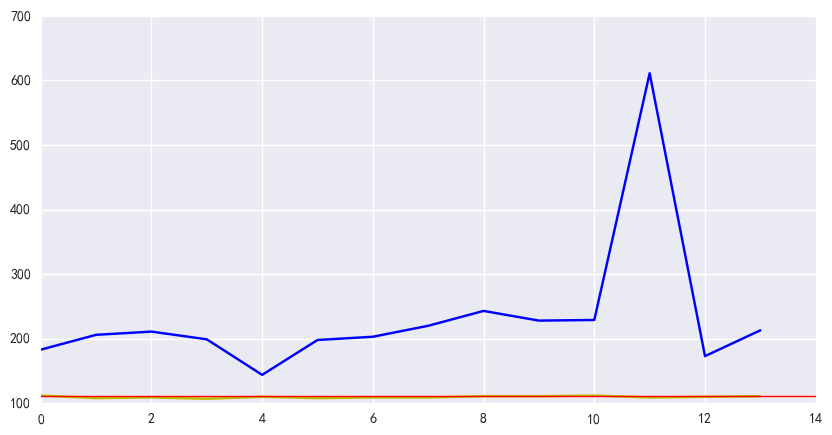

In [14]:
predict_date = pd.date_range(start='10/18/2016', end='10/31/2016', freq='D', normalize=True)
m = shop_open_dates.shape[0];
pridicts = {}
temp = 0
id = 1591
train_df = initTrainData(id)
train_mean = train_df['count'].mean()
#print(train_df)
#print('train_df size=%d'%(train_df.shape[0]))
print(train_df[train_df['max'].isnull()].index)
params = {'n_estimators': 30, 'max_depth': 3, 'min_samples_split': 3,
          'learning_rate': 0.01, 'loss': 'ls'}

for date in predict_date:
    X_train, y_train = train_df.drop('count',axis=1), train_df['count']
    clf = trainModel(X_train, y_train, params)

    series = initNextDayData(date, train_df, id)
    next_dataframe = series.to_frame().T
    next_dataframe['holiday'] = next_dataframe['holiday'].astype(np.int32);
    #print(next_dataframe)
    count = predictNextDay(next_dataframe)
    series['count'] = count;
    temp = series.to_frame()
    #print(temp)
    train_df = train_df.append(series, ignore_index = True)
    train_df['count'] = train_df['count'].astype(np.int32);
    train_df['holiday'] = train_df['holiday'].astype(np.int32);

y_Test = getTestCount(id).values
y_Pred = train_df.iloc[-14:]['count'].apply(lambda x: 0 if x<0 else x).values
e = base.evaluation(y_Test, y_Pred)
e_tm = base.evaluation_tm(y_Test, train_mean)
print("id=%d evaluation=%f"%(id, e))
print("id=%d evaluation_tm=%f"%(id, e_tm))
print(y_Test)
print(y_Pred)

PlotPredAndTestPayCount(y_Test, y_Pred, train_mean)

id=1 evaluation=0.061305
id=2 evaluation=0.324787
id=3 evaluation=0.119047
id=4 evaluation=0.148116
id=5 evaluation=0.235515
id=6 evaluation=0.060431
id=7 evaluation=0.111045
id=8 evaluation=0.097364
id=9 evaluation=0.063952
id=10 evaluation=0.077540
id=11 evaluation=0.077523
id=12 evaluation=0.193749
id=13 evaluation=0.033371
id=14 evaluation=0.067497
id=15 evaluation=0.085265
id=16 evaluation=0.174421
id=17 evaluation=0.068194
id=18 evaluation=0.222192
id=19 evaluation=0.097424
id=20 evaluation=0.038886
id=21 evaluation=0.091135
id=22 evaluation=0.147430
id=23 evaluation=0.413772
id=24 evaluation=0.180989
id=25 evaluation=0.073273
id=26 evaluation=0.156836
id=27 evaluation=0.072220
id=28 evaluation=0.109121
id=29 evaluation=0.117003
id=30 evaluation=0.173328
id=31 evaluation=0.100754
id=32 evaluation=0.200190
id=33 evaluation=0.128257
id=34 evaluation=0.069520
id=35 evaluation=0.134154
id=36 evaluation=0.076524
id=37 evaluation=0.059575
id=38 evaluation=0.136493
id=39 evaluation=0.15

In [38]:
#前一周均值预测
predict_date = pd.date_range(start='10/18/2016', end='10/31/2016', freq='D', normalize=True)
m = shop_open_dates.shape[0];
pridicts = {}
temp = 0
evaluations = {}
for id in range(1, 2001):
    train_df = initTrainData(id)  
    train_mean = train_df['count'].mean()
    y_Test = getTestCount(id).values;
    e = base.evaluation_tm(y_Test, train_mean)
    print("id=%d evaluation=%f"%(id, e))
    #e_tm = base.evaluation_tm(y_Test, )
    #pridicts[id] = y_Pred
    evaluations[id] = e

mean_evaluation_df = pd.DataFrame.from_dict(evaluations, orient='index');
mean_evaluation_df.columns = ['evaluation']
mean_evaluation_df.index.name = 'id'
mean_evaluation_df.sort_values('evaluation')
mean_evaluation_df.to_csv("./data/dataset/dataset/mean_evaluation.txt", sep='\t', index=True, encoding='UTF-8')


id=1 evaluation=0.065297
id=2 evaluation=0.322848
id=3 evaluation=0.134336
id=4 evaluation=0.192835
id=5 evaluation=0.219794
id=6 evaluation=0.109828
id=7 evaluation=0.115920
id=8 evaluation=0.130054
id=9 evaluation=0.063390
id=10 evaluation=0.100755
id=11 evaluation=0.097944
id=12 evaluation=0.121897
id=13 evaluation=0.031582
id=14 evaluation=0.068437
id=15 evaluation=0.084532
id=16 evaluation=0.091605
id=17 evaluation=0.069021
id=18 evaluation=0.225406
id=19 evaluation=0.119537
id=20 evaluation=0.047623
id=21 evaluation=0.109729
id=22 evaluation=0.070548
id=23 evaluation=0.459228
id=24 evaluation=0.174558
id=25 evaluation=0.060160
id=26 evaluation=0.168206
id=27 evaluation=0.054204
id=28 evaluation=0.108466
id=29 evaluation=0.151976
id=30 evaluation=0.098906
id=31 evaluation=0.144057
id=32 evaluation=0.217827
id=33 evaluation=0.106463
id=34 evaluation=0.083582
id=35 evaluation=0.148431
id=36 evaluation=0.069829
id=37 evaluation=0.072084
id=38 evaluation=0.144711
id=39 evaluation=0.11